In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# load the train and test data

train = loadmat('../Data/train_32x32.mat')
test = loadmat('../Data/test_32x32.mat')

In [3]:
# loadmat outputs a dictionary with the keys 'X' as the photos and 'y' as the labels

train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [4]:
# load the images and labels as arrays

train_img = np.array(train['X'])
test_img = np.array(test['X'])

train_labels = train['y']
test_labels = test['y']

In [5]:
# check the shape of the data

print(train_img.shape)
print(test_img.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


#### We see for the training set we have 73,257 images at the size of 32x32 with 3 color channels: red, green, and blue. The test set has 26,032 images with the same characteristics.

In [6]:
# rearrange the data for ease of use 

train_img = np.moveaxis(train_img, 3, 0)
test_img = np.moveaxis(test_img, 3, 0)

In [7]:
print(train_img.shape)
print(test_img.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


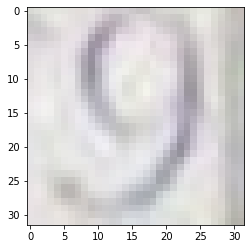

Image label:  [9]


In [8]:
# check out in image
# plot a random image and its label

plt.imshow(train_img[73256])
plt.show()

print('Image label: ', train_labels[73256])

In [9]:
# one-hot encode the train and test labels
# scikit-learn's LabelBinarizer is used due to the labels being 1 dimensional

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [10]:
# split the training data into train and validation sets

X_train, X_valid, y_train, y_valid = train_test_split(train_img, train_labels, test_size=0.15, random_state=42)

In [11]:
# implement ImageDataGenerator to augment the images to easily create more data

augdata = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In [13]:
# create lr model for determining the optimal learning rate

lr_model = Sequential()
# layer 1
lr_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(32, 32, 3))),
# add a normalization layer to regularize and accelerate the training process
lr_model.add(BatchNormalization()),
# layer 2
lr_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')),
lr_model.add(MaxPooling2D(pool_size=2)),
lr_model.add(Dropout(0.3)),
# layer 3
lr_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')),
lr_model.add(BatchNormalization()),
# layer 4
lr_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')),
lr_model.add(MaxPooling2D(pool_size=2)),
lr_model.add(Dropout(0.3)),
# layer 5
lr_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')),
lr_model.add(BatchNormalization()),
# layer 6
lr_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')),
lr_model.add(MaxPooling2D(pool_size=2)),
lr_model.add(Dropout(0.3)),
# layer 7
lr_model.add(Flatten()),
lr_model.add(Dense(units=128, activation='relu')),
lr_model.add(Dropout(0.4)),
# layer 8
lr_model.add(Dense(units=10, activation='softmax'))

# define a learning rate scheduler in order to iterate through the range of potential learning rates
# the lambda function creates a range from 0.0001 increasing with each epoch to 0.1
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 0.0001 * 10**(epoch / 10))

# define the Adam optimizer for faster weight optimization
optimizer = keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)

# compile the model with loss calculated using categorical crossentropy and metrics focused on accuracy
# categorical crossentropy is used due to the number of label classes which are one-hot encoded
# accuracy = how often the predictions match the labels
lr_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
lr_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)       

In [15]:
# fit the model implementing lr_schedule for future plotting of the learning rates

lr_report = lr_model.fit(augdata.flow(X_train, y_train, batch_size=128),
                         epochs=30,
                         validation_data=(X_valid, y_valid),
                         callbacks=[lr_schedule],
                         verbose=2)

Epoch 1/30
487/487 - 129s - loss: 2.4754 - accuracy: 0.1435 - val_loss: 2.2440 - val_accuracy: 0.1940
Epoch 2/30
487/487 - 140s - loss: 2.2631 - accuracy: 0.1696 - val_loss: 2.2126 - val_accuracy: 0.1937
Epoch 3/30
487/487 - 141s - loss: 2.2040 - accuracy: 0.1912 - val_loss: 2.1499 - val_accuracy: 0.2474
Epoch 4/30
487/487 - 159s - loss: 1.8377 - accuracy: 0.3496 - val_loss: 1.3550 - val_accuracy: 0.5587
Epoch 5/30
487/487 - 157s - loss: 1.3595 - accuracy: 0.5368 - val_loss: 0.8732 - val_accuracy: 0.7278
Epoch 6/30
487/487 - 154s - loss: 1.0612 - accuracy: 0.6506 - val_loss: 0.5932 - val_accuracy: 0.8274
Epoch 7/30
487/487 - 150s - loss: 0.8670 - accuracy: 0.7205 - val_loss: 0.4682 - val_accuracy: 0.8610
Epoch 8/30
487/487 - 146s - loss: 0.7328 - accuracy: 0.7697 - val_loss: 0.4158 - val_accuracy: 0.8731
Epoch 9/30
487/487 - 144s - loss: 0.6404 - accuracy: 0.8002 - val_loss: 0.4452 - val_accuracy: 0.8650
Epoch 10/30
487/487 - 143s - loss: 0.5800 - accuracy: 0.8214 - val_loss: 0.3248 - 

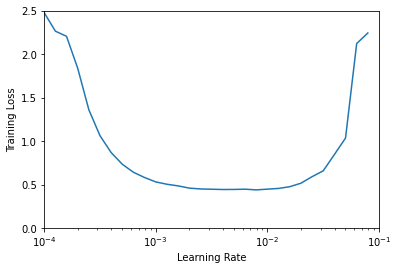

In [16]:
# plot learning rate versus loss to visually determine the best learning rate

plt.semilogx(lr_report.history['lr'], lr_report.history['loss'])
plt.axis([0.0001, 0.1, 0, 2.5])
plt.xlabel('Learning Rate')
plt.ylabel('Training Loss')
plt.show()

#### The learning rate seems to be most stable between 0.01 and 0.1. I'll go with a learning rate of 0.01 when compiling my model.

In [ ]:
# create the model

model = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=2),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=2),
    Dropout(0.3),
    
    Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=2),
    Dropout(0.3),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

In [17]:
# create the model

# begin with 32 filters for the first layers
model = Sequential()
model.add(Conv2D(32, kernel_size=3, input_shape=(32, 32, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, 3, padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

# double the filters to 64 keeping all other arguments the same
model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, 3, padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

# double the filters to 128 keeping all other arguments the same
model.add(Conv2D(128, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, 3, padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(10, activation='softmax'))

In [18]:
# create an EarlyStopping callback to prevent overfitting

early_stopping = EarlyStopping(patience=5)

# compile the model using our preferred learning rate of 0.01
# loss is calculated using categorical crossentropy
# metrics focused on accuracy

model.compile(optimizer=Adam(learning_rate=0.01, amsgrad=True), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)       

In [20]:
report = model.fit(augdata.flow(X_train, y_train, batch_size=128),
                   epochs=30,
                   validation_data=(X_valid, y_valid),
                   # added early stopping callback to reduce overfitting
                   callbacks=[early_stopping],
                   verbose=2)

Epoch 1/30
487/487 - 161s - loss: 2.1802 - accuracy: 0.2439 - val_loss: 2.3692 - val_accuracy: 0.1673
Epoch 2/30
487/487 - 182s - loss: 0.9283 - accuracy: 0.7040 - val_loss: 0.4354 - val_accuracy: 0.8693
Epoch 3/30
487/487 - 189s - loss: 0.5514 - accuracy: 0.8348 - val_loss: 0.3401 - val_accuracy: 0.8978
Epoch 4/30
487/487 - 184s - loss: 0.4669 - accuracy: 0.8627 - val_loss: 0.2894 - val_accuracy: 0.9159
Epoch 5/30
487/487 - 184s - loss: 0.4208 - accuracy: 0.8784 - val_loss: 0.2774 - val_accuracy: 0.9179
Epoch 6/30
487/487 - 184s - loss: 0.3839 - accuracy: 0.8897 - val_loss: 0.2802 - val_accuracy: 0.9205
Epoch 7/30
487/487 - 184s - loss: 0.3659 - accuracy: 0.8953 - val_loss: 0.4808 - val_accuracy: 0.8524
Epoch 8/30
487/487 - 190s - loss: 0.3484 - accuracy: 0.9001 - val_loss: 0.2660 - val_accuracy: 0.9251
Epoch 9/30
487/487 - 191s - loss: 0.3314 - accuracy: 0.9057 - val_loss: 0.2649 - val_accuracy: 0.9254
Epoch 10/30
487/487 - 186s - loss: 0.3195 - accuracy: 0.9095 - val_loss: 0.2715 - 

#### After running through 30 epochs we see our training accuracy has increased up to 93.8% and validation accuracy to 94.8%. Had we run more epochs it's possible that the accuracy could have possibly gotten better. However, for the sake of processing time and the fear of overfitting I'll say 30 epochs is good for now.

In [21]:
# report the results of the model on the training and validation sets

train_accuracy = report.history['accuracy']
valid_accuracy = report.history['val_accuracy']

train_loss = report.history['loss']
valid_loss = report.history['val_loss']

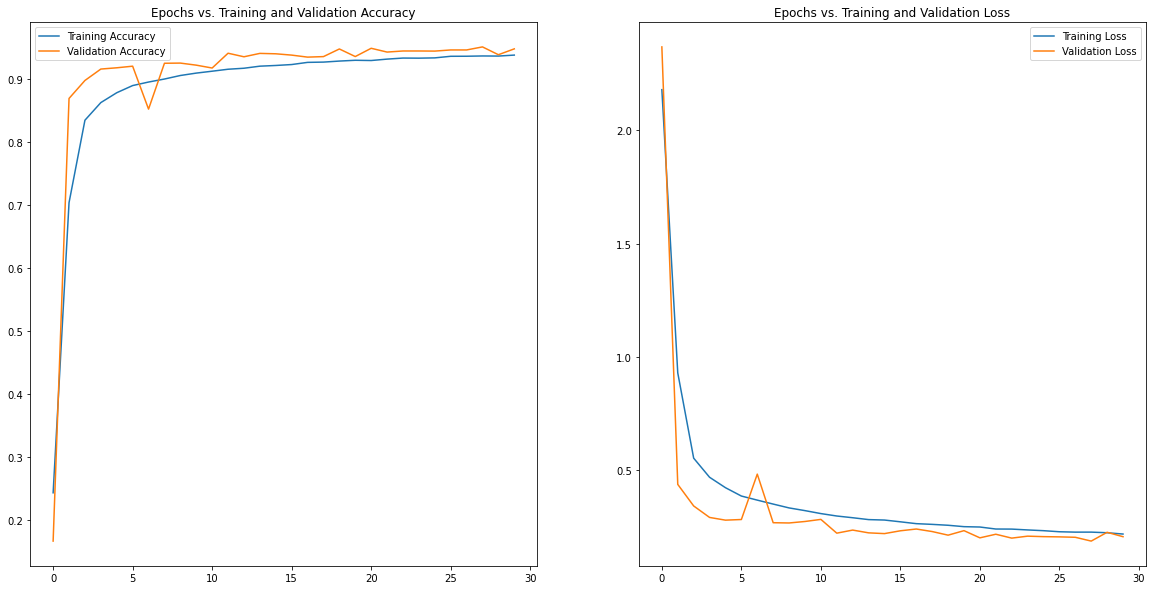

In [23]:
# visualize the epochs vs. train and validation accuracy and loss

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

#### The plots give us a good visual representation of the progress the model made toward higher accuracy and lower loss.

#### Now I'll evaluate the model on the unseen test data.

In [26]:
# evaluate the model on test data

test_loss, test_accuracy = model.evaluate(x=test_img, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.format(test_accuracy, test_loss))

Test accuracy is: 0.9522 
Test loss is: 0.1850


#### The model performed even better on the test data than the training and validation sets.